# Infomación de entrega

**Nombre estudiante:**


## 0) Setup

In [1]:
!pip install keras --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 10.3 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1


In [2]:
# Importar librerías

In [3]:
from pathlib import Path
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import BatchNormalization, Dropout


## 1) Carga del dataset

El dataset Cora consiste en 2.708 papers científicos clasificados en una de 7 posibles clases. La red de citas/referencias consiste en 5.429 arcos. Cada paper tiene un vector de palabras binario de tamaño 1.433, indicando la presencia o ausencia de la palabra correspondiente.

El dataset tiene dos archivos separados:

1. El archivo `cora.cites` incluye las citas/referencias en dos columnas:
`cited_paper_id` (*target*) y `citing_paper_id` (*source*).
2. El archivo `cora.content` incluye una descripción del contenido del paper en 1.435 columnas: `paper_id`, `subject`, y 1.433 *features* binarias.


In [112]:
# Descarga de datos
!mkdir -p ./data/cora
!wget https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz -O ./data/cora.tgz
!tar -xvzf ./data/cora.tgz -C ./data/cora/ --strip-components=1

--2024-10-29 11:35:32--  https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz
Resolving linqs-data.soe.ucsc.edu (linqs-data.soe.ucsc.edu)... 128.114.47.74
Connecting to linqs-data.soe.ucsc.edu (linqs-data.soe.ucsc.edu)|128.114.47.74|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168052 (164K) [application/x-gzip]
Saving to: ‘./data/cora.tgz’

./data/cora.tgz     100%[===================>] 164.11K   305KB/s    in 0.5s    

2024-10-29 11:35:34 (305 KB/s) - ‘./data/cora.tgz’ saved [168052/168052]

cora/README
cora/cora.cites
cora/cora.content


In [113]:
# Cargar datos utilizando pandas

In [114]:
citations = pd.read_csv(
    Path("data", "cora", "cora.cites"),
    names=["target", "source"],
    sep="\t",
    header=None,
)
print("Citations shape:", citations.shape)

Citations shape: (5429, 2)


In [115]:
citations.head()

,target,source
0,35,1033
1,35,103482
2,35,103515
3,35,1050679
4,35,1103960


In [116]:
citations.sample(frac=1).head()

,target,source
2480,25184,285675
2928,36140,63915
69,35,206371
5221,643239,643221
4176,134315,23069


In [117]:
# Cargar el archivo `cora.content` en un DataFrame
content = pd.read_csv(
    Path("data", "cora", "cora.content"),  # Especifica la ruta del archivo
    sep="\t",  # Especifica que las columnas están separadas por tabulaciones
    header=None  # Indica que el archivo no tiene encabezado en la primera fila
)

# Renombrar las columnas para mejorar la legibilidad
content.columns = ["paper_id"] + [f"term_{i}" for i in range(1433)] + ["subject"]

# Mostrar las primeras filas de la tabla
content.head()


,paper_id,term_0,term_1,term_2,term_3,term_4,term_5,term_6,term_7,term_8,...,term_1424,term_1425,term_1426,term_1427,term_1428,term_1429,term_1430,term_1431,term_1432,subject
0,31336,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,Neural_Networks
1,1061127,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,Rule_Learning
2,1106406,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
3,13195,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
4,37879,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Probabilistic_Methods


El código carga y prepara el archivo cora.content, asignándole nombres a las columnas y mostrando la dimensión del conjunto de datos.

In [118]:
column_names = ["paper_id"] + [f"term_{idx}" for idx in range(1433)] + ["subject"]
papers = pd.read_csv(Path("data", "cora", "cora.content"), sep="\t", header=None, names=column_names)
print("Papers shape:", papers.shape)

Papers shape: (2708, 1435)


In [119]:
papers.sample(5).T

,2163,113,698,18,1332
paper_id,899085,853150,33412,49482,1129369
term_0,0,0,0,0,0
term_1,0,0,0,0,0
term_2,0,0,0,0,0
term_3,0,0,0,0,0
...,...,...,...,...,...
term_1429,0,0,0,0,0
term_1430,0,0,0,0,0
term_1431,1,0,0,0,0
term_1432,0,0,0,0,0


In [120]:
print(papers.subject.value_counts())

subject
Neural_Networks           818
Probabilistic_Methods     426
Genetic_Algorithms        418
Theory                    351
Case_Based                298
Reinforcement_Learning    217
Rule_Learning             180
Name: count, dtype: int64


In [121]:
class_values = sorted(papers["subject"].unique())
class_idx = {name: id for id, name in enumerate(class_values)}
paper_idx = {name: idx for idx, name in enumerate(sorted(papers["paper_id"].unique()))}

papers["paper_id"] = papers["paper_id"].apply(lambda name: paper_idx[name])
citations["source"] = citations["source"].apply(lambda name: paper_idx[name])
citations["target"] = citations["target"].apply(lambda name: paper_idx[name])
papers["subject"] = papers["subject"].apply(lambda value: class_idx[value])

#### Preguntas

Una vez cargado el dataset debes responder las siguientes preguntas:

1. ¿Qué tipos de nodos y aristas tiene el grafo?

2. ¿Cuántas features tiene cada nodo?

3. ¿Cuántos nodos y aristas forman el grafo?


#### Respuestas

1. ...
2. ...
3. ...
4. ...
5. ...

## 2) Análisis del grafo

Un paso importante antes de aplicar *machine learning* sobre un conjunto de datos es el análisis de datos. Para esto, aprovecharemos de usar la librería NetworkX para obtener información sobre nuestro grafo.

In [122]:
# Crear grafo en NetworkX con datos cargados

In [123]:
%%time
cora_graph = nx.from_pandas_edgelist(citations.sample(n=2000))  # Nuevo grafo
pos = nx.spring_layout(cora_graph, seed=0)  # Posición de los nodos

CPU times: user 18.2 s, sys: 26.2 ms, total: 18.3 s
Wall time: 18.9 s


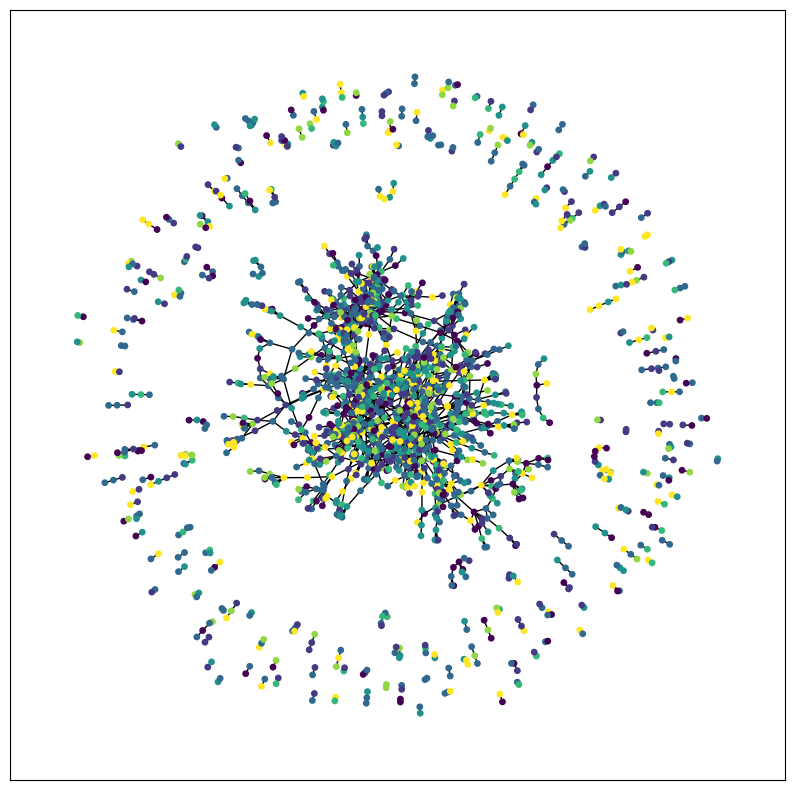

In [124]:
plt.figure(figsize=(10, 10))
colors = papers["subject"].tolist()
subjects = list(papers[papers["paper_id"].isin(list(cora_graph.nodes))]["subject"])
nx.draw_networkx(cora_graph, pos=pos, node_size=15, node_color=subjects, with_labels=False)  # Gráfico

#### Preguntas

Una vez instanciado el grafo, debes responder las siguientes preguntas utilizando NetworkX:

1. ¿Cuál es el grado promedio de los nodos en el grafo?

2. ¿Cuál es el diámetro del grafo?

3. ¿Cuál es la densidad de la matriz de adyacencia del grafo?

4. Realizar un gráfico mostrando los nodos (un subconjunto) y sus arcos respectivos


## 3) Split del dataset


Otro paso importante es realizar la partición de datos etiquetados en conjuntos de entrenamiento y test. Para esto, para cada etiqueta, se debe tomar la mitad de los papers para cada conjunto (50%).

In [125]:
# Partición de datos en train y test como numpy array

In [126]:
train_data, test_data = [], []

for _, group_data in papers.groupby("subject"):
    # Seleccionamos cerca del 50% del dataset para entrenamiento
    random_selection = np.random.rand(len(group_data.index)) <= 0.5
    train_data.append(group_data[random_selection])
    test_data.append(group_data[~random_selection])

train_data = pd.concat(train_data).sample(frac=1)
test_data = pd.concat(test_data).sample(frac=1)

print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (1343, 1435)
Test data shape: (1365, 1435)


#### Preguntas

1. ¿En qué formato se encuentran almacenados los splits?
2. ¿Qué podría ocurrir si no realizamos la partición sobre cada etiqueta sino que sobre todo el conjunto de datos directamente (es decir, no haceerlo de manera estratificada)?
3. ¿Estamos en presencia de un contexto inductivo o transductivo?
4. Mencione un ejemplo de técnica de *data augmentation* que podría aplicar en este conjunto de datos.
5. Si tuviéramos los *timestamps* de cada paper (es decir, cuando se publicó cada paper), ¿podríamos usar esta información en este paso? Si es así, ¿cómo podríamos utilizar el momento de publicación de cada paper para particionar los datos?

## 4) Creacion de la red

### GCN

En este paso, deberás crear una GCN. Para esto, deberás definir la clase `GraphConvLayer` que solo deberá recibir como parámetro la cantidad de capas ocultas a utilizar en el paso de cálculo de mensajes.

En esta implementación de la GCN, los pasos a implementar son:

$h_v^{(l)} = \text{ADD}(\text{MEAN}(\{W^{(l)} \times h_u^{(l-1)}, u\in N(v)\}), W^{(l)} \times h_v^{(l-1)})$

1. Cálculo del mensaje
2. Agregación de los mensajes de vecinos (usar promedio)
3. Actualizar *embedding* de cada nodo usando la suma de los mensajes agregados y la representación actual del nodo.

Por otra parte, para definir la GCN deberás definir la clase `GCNNodeClassifier`, que también recibirá como parámetro la cantidad de capas ocultas a utilizar.

Las capas del modelo `GCNNodeClassifier` que debes crear son:

1. Una sección de FFN que tenga `hidden_units` unidades ocultas
2. Una capa convolucional (`GraphConvLayer`) que reciba el parámetro `hidden_units`.
3. Una capa densa para clasificar las `num_classes` unidades.

Notar que cada capa densa de una FFN deberá utilizar *batch normalization*, *dropout* (0.3) y activación ReLU. Asegúrate que las capas internas sean parte del modelo.

In [127]:
# Hiperparámetros GCN (definir como CONSTANTES)

In [128]:
# Funciones auxiliares (por ejemplo, para crear una FNN)

In [129]:
# Clase GraphConvLayer

In [130]:
# Clase GCNNodeClassifier

Crea una instancia de tu modelo que reciba la información del grafo, el número de clases, y `[8, 16]` como valor para `hidden_units`. Imprime las capas de tu instancia del modelo.

In [131]:
# Creación de modelo e impresión de parámetros

In [132]:
hidden_units = [32, 16]
learning_rate = 0.01
num_epochs = 300
batch_size = 256

In [133]:
def run_experiment(model, x_train, y_train):
    # Compilar modelo
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
    )
    # Creación de callback paara early stopping
    early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_acc", patience=50, restore_best_weights=True
    )
    # Entrenamiento del modelo
    history = model.fit(
        x=x_train,
        y=y_train,
        epochs=num_epochs,
        batch_size=batch_size,
        validation_split=0.15,
        callbacks=[early_stopping],
    )

    return history

In [134]:
def display_learning_curves(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history.history["loss"])
    ax1.plot(history.history["val_loss"])
    ax1.legend(["train", "test"], loc="upper right")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")

    ax2.plot(history.history["acc"])
    ax2.plot(history.history["val_acc"])
    ax2.legend(["train", "test"], loc="upper right")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    plt.show()

In [135]:
def create_ffn(units, name=None):
    fnn_layers = [
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(units, activation=tf.nn.gelu)
    ]
    return keras.Sequential(fnn_layers, name=name)

In [136]:
feature_names = list(set(papers.columns) - {"paper_id", "subject"})
num_features = len(feature_names)
num_classes = len(class_idx)

# Separamos las features de entrenamiento y test como numpy array
x_train = train_data[feature_names].to_numpy()
x_test = test_data[feature_names].to_numpy()
# Separamos las etiquetas de entrenamiento y test como numpy array
y_train = train_data["subject"]
y_test = test_data["subject"]

In [137]:
# Create an edges array (sparse adjacency matrix) of shape [2, num_edges].
edges = citations[["source", "target"]].to_numpy().T
# Create a node features array of shape [num_nodes, num_features].
node_features = tf.cast(
    papers.sort_values("paper_id")[feature_names].to_numpy(), dtype=tf.dtypes.float32
)
# Create graph info tuple with node_features and edges
graph_info = (node_features, edges)

print("Edges shape:", edges.shape)
print("Nodes shape:", node_features.shape)

Edges shape: (2, 5429)
Nodes shape: (2708, 1433)


In [138]:
# class GraphConvLayer(layers.Layer):
#     def __init__(self, hidden_units: int, *args, **kwargs):
#         super().__init__(*args, **kwargs)
#         self.ffn_prepare = create_ffn(hidden_units)
#         self.update_fn = create_ffn(hidden_units)

#     def prepare(self, node_representations):
#         # node_representations.shape = [num_edges, embedding_dim]
#         # Cacular los mensajes (MSG) de los vecinos
#         messages = self.ffn_prepare(node_representations)
#         return messages

#     def aggregate(self, node_indices, neighbour_messages, node_representations):
#         # node_indices.shape = [num_edges]
#         # neighbour_messages.shape = [num_edges, representation_dim]
#         # node_representations.shape = [num_nodes, representation_dim]
#         # Aggregar (AGG) los mensajes de los vecinos calculando el promedio
#         num_nodes = node_representations.shape[0]
#         aggregated_message = tf.math.unsorted_segment_mean(
#             neighbour_messages, node_indices, num_segments=num_nodes
#         )
#         return aggregated_message

#     def update(self, node_representations, aggregated_messages):
#         # node_representations.shape = [num_nodes, representation_dim]
#         # aggregated_messages.shape = [num_nodes, representation_dim]
#         # Actualizamos la representación de cada nodo con la nueva (CONCAT)
#         h = tf.concat([node_representations, aggregated_messages], axis=1)

#         # Aplicamos la función de procesamiento
#         node_embeddings = self.update_fn(h)
#         node_embeddings = tf.nn.l2_normalize(node_embeddings, axis=-1)
#         return node_embeddings

#     def call(self, node_representations, edges):
#         """Process the inputs to produce the node_embeddings.

#         inputs: a tuple of two elements: node_representations and edges
#         Returns: node_embeddings of shape [num_nodes, representation_dim].
#         """

#         # Recuperamos los nodos de inicio (node_indices) y de llegada (neighbour_indices) desde los arcos
#         node_indices, neighbour_indices = edges[0], edges[1]
#         # neighbour_repesentations.shape = [num_edges, representation_dim]
#         neighbour_repesentations = tf.gather(node_representations, neighbour_indices)

#         # GCN:
#         # 1. Preparamos los mensajes de los vecinos
#         neighbour_messages = self.prepare(neighbour_repesentations)
#         # 2. Agregamos los mensajes de los vecinos
#         aggregated_messages = self.aggregate(node_indices, neighbour_repesentations, node_representations)
#         # 3. Actualizamos los embeddings de los nodos con los mensajes de los vecinos
#         return self.update(node_representations, aggregated_messages)

In [139]:
# class GNNNodeClassifier(tf.keras.Model):
#     def __init__(
#         self,
#         graph_info,
#         num_classes,
#         hidden_units,
#         *args,
#         **kwargs,
#     ):
#         super().__init__(*args, **kwargs)
#         # Unpack graph_info to two elements: node_features and edges
#         node_features, edges = graph_info
#         self.node_features = node_features
#         self.edges = edges

#         # Preprocessing layer
#         self.preprocess = create_ffn(hidden_units, name="preprocess")
#         # Two GraphConv layers
#         self.conv1 = GraphConvLayer(hidden_units, name="graph_conv1")
#         # self.sage1 = SageConvLayer(hidden_units, name="sage_conv1")
#         # Dense layer for classification
#         self.compute_logits = layers.Dense(units=num_classes, name="logits")

#     def call(self, input_node_indices):
#         x = self.preprocess(self.node_features)
#         x = self.conv1(x, self.edges)
#         # x = self.sage1(x, self.edges)
#         node_embeddings = tf.gather(x, input_node_indices)
#         return self.compute_logits(node_embeddings)

In [140]:
# # Definir los parámetros de entrada
# graph_info = (node_features, edges)  # Asegúrate de que esto esté definido correctamente
# num_classes = 10  # Cambia esto según tu número de clases
# hidden_units = 64  # Cambia esto según tus necesidades

# # Instanciar el modelo GNN
# gnn_model = GNNNodeClassifier(
#     graph_info=graph_info,
#     num_classes=num_classes,
#     hidden_units=hidden_units,
#     name="gnn_model"
# )

# # Crear una entrada dummy para construir el modelo
# dummy_input = tf.constant([0])  # Asumiendo que la entrada es un índice entero de nodos
# _ = gnn_model(dummy_input)       # Ejecuta una pasada con el dummy_input

# # Obtener el resumen del modelo
# gnn_model.summary()


In [141]:
# tf.keras.utils.plot_model(gnn_model, show_shapes=True, show_layer_names=True, expand_nested=True)

In [142]:
# x_train = train_data.paper_id.to_numpy()
# history = run_experiment(gnn_model, x_train, y_train)

In [143]:
# display_learning_curves(history)

In [144]:
# x_test = test_data.paper_id.to_numpy()
# _, test_accuracy = gnn_model.evaluate(x=x_test, y=y_test, verbose=0)
# print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

#### Preguntas

1. ¿Cuántas capas tiene, en total, el modelo?
2. ¿Cuántos parámetros entrenables tiene, en total, el modelo?

### Sage

En este paso, deberás crear otra GCN. Para esto, deberás definir la clase `GraphSageLayer` que solo deberá recibir como parámetro la cantidad de capas ocultas a utilizar en el paso de cálculo de mensajes.

En esta implementación de la GCN, los pasos a implementar son:

$h_v^{(l)} = W^{(l)}\times \text{CONCAT}(h_v^{(l-1)}, \text{MEAN}(\{h_u^{(l-1)}, u\in N(v)\}))$

1. Agregación de los mensajes de vecinos (usar promedio)
2. Actualizar *embedding* de cada nodo usando la concatenación de los mensajes agregados y la representación actual del nodo.
3. Cálculo del mensaje

Por otra parte, para definir la GCN deberás definir la clase `GSNNodeClassifier`, que también recibirá como parámetro la cantidad de capas ocultas a utilizar.

Las capas del modelo `GSNNodeClassifier` que debes crear son:

1. Una sección de FFN que tenga `hidden_units` unidades ocultas
2. Una capa convolucional (`GraphSageLayer`) que reciba el parámetro `hidden_units`.
3. Una capa densa para clasificar las `num_classes` unidades.

Notar que cada capa densa de una FFN deberá utilizar *batch normalization*, *dropout* (0.3) y activación ReLU. Asegúrate que las capas internas sean parte del modelo.

In [145]:
# Hiperparámetros GCN (definir como CONSTANTES)

In [146]:
# Funciones auxiliares (por ejemplo, para crear una FNN)

In [147]:
# Clase GraphSageLayer

In [148]:
# Clase GSNNodeClassifier

Crea una instancia de tu modelo que reciba la información del grafo, el número de clases, y `[8, 16]` como valor para `hidden_units`. Imprime las capas de tu instancia del modelo.

In [149]:
# Creación de modelo e impresión de parámetros

In [150]:

# # Definición de la función para construir un MLP para cada etapa de procesamiento en SageConvLayer
# def create_ffn(hidden_units: int):
#     return Sequential([
#         layers.Dense(hidden_units, activation="relu"),
#         layers.Dropout(0.5),  # Ajusta el dropout según lo necesario
#         layers.Dense(hidden_units, activation="relu")
#     ])

In [151]:
class SageConvLayer(layers.Layer):
    def __init__(self, hidden_units: int, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.ffn_prepare = create_ffn(hidden_units)
        self.update_fn = create_ffn(hidden_units)

    def prepare(self, node_representations: tf.Tensor) -> tf.Tensor:
        # node_representations.shape = [num_edges, embedding_dim]
        # Cacular los mensajes (MSG) de los vecinos
        messages = self.ffn_prepare(node_representations)
        return messages

    def aggregate(self, node_indices: tf.Tensor, neighbour_messages: tf.Tensor,
                  node_representations: tf.Tensor) -> tf.Tensor:
        # node_indices.shape = [num_edges]
        # neighbour_messages.shape = [num_edges, representation_dim]
        # node_representations.shape = [num_nodes, representation_dim]
        # Aggregar (AGG) los mensajes de los vecinos calculando el promedio
        num_nodes = node_representations.shape[0]
        aggregated_message = tf.math.unsorted_segment_mean(#AQUI DEBE IR MEAN (PROMEDIO)
            neighbour_messages, node_indices, num_segments=num_nodes
        )
        return aggregated_message

    def update(self, node_representations: tf.Tensor, aggregated_messages: tf.Tensor) -> tf.Tensor:
        # node_representations.shape = [num_nodes, representation_dim]
        # aggregated_messages.shape = [num_nodes, representation_dim]
        # Actualizamos la representación de cada nodo con la nueva (CONCAT)
        h = tf.concat([node_representations, aggregated_messages], axis=1)

        # Aplicamos la función de procesamiento
        node_embeddings = self.update_fn(h)
        node_embeddings = tf.nn.l2_normalize(node_embeddings, axis=-1)
        return node_embeddings

    def call(self, inputs: tuple[tf.Tensor, tf.Tensor]) -> tf.Tensor:
        """Process the inputs to produce the node_embeddings.

        inputs: a tuple of two elements: node_representations and edges
        Returns: node_embeddings of shape [num_nodes, representation_dim].
        """
        node_representations, edges = inputs
        # Recuperamos los nodos de inicio (node_indices) y de llegada (neighbour_indices) desde los arcos
        node_indices, neighbour_indices = edges[0], edges[1]
        # neighbour_repesentations.shape = [num_edges, representation_dim]
        neighbour_representations = tf.gather(node_representations, neighbour_indices)

        # SAGE:
        # 1. Agregar los mensajes de los vecinos
        aggregated_messages = self.aggregate(node_indices, neighbour_representations, node_representations)
        # 2. Actualizamos los embeddings de los nodos con los mensajes de los vecinos
        updated_messages = self.update(node_representations, aggregated_messages)
        # 3. Preparar los mensajes resultantes
        return self.prepare(updated_messages)

In [152]:
class GNNNodeClassifier(tf.keras.Model):
    def __init__(
        self,
        graph_info,
        num_classes,
        hidden_units,
        *args,
        **kwargs,
    ):
        super().__init__(*args, **kwargs)
        node_features, edges = graph_info
        self.node_features = node_features
        self.edges = edges

        # Preprocessing layer
        self.preprocess = create_ffn(hidden_units, name="preprocess")
        # Capa SAGE
        self.sage1 = SageConvLayer(hidden_units, name="sage_conv1")
        # Capa densa para la clasificación
        self.compute_logits = layers.Dense(units=num_classes, name="logits")

    def call(self, inputs: tuple[tf.Tensor, tf.Tensor]) -> tf.Tensor:
        """Process the inputs to produce the node_embeddings.

        inputs: a tuple of two elements: node_representations and edges
        Returns: node_embeddings of shape [num_nodes, representation_dim].
        """
        node_representations, edges = inputs
        # Recuperamos los nodos de inicio (node_indices) y de llegada (neighbour_indices) desde los arcos
        node_indices, neighbour_indices = edges[0], edges[1]
        # neighbour_repesentations.shape = [num_edges, representation_dim]
        neighbour_representations = tf.gather(node_representations, neighbour_indices)

        # SAGE:
        # 1. Agregar los mensajes de los vecinos
        aggregated_messages = self.aggregate(node_indices, neighbour_representations, node_representations)
        # 2. Actualizamos los embeddings de los nodos con los mensajes de los vecinos
        updated_messages = self.update(node_representations, aggregated_messages)
        # 3. Preparar los mensajes resultantes
        return self.prepare(updated_messages)



In [153]:
x_train = train_data.paper_id.to_numpy()
history = run_experiment(gnn_model, x_train, y_train)

Epoch 1/300


TypeError: Exception encountered when calling GNNNodeClassifier.call().

[1mtoo many positional arguments[0m

Arguments received by GNNNodeClassifier.call():
  • input_node_indices=tf.Tensor(shape=(None,), dtype=int64)

In [ ]:
# Prepara los índices de los nodos para el entrenamiento
x_train = train_data[feature_names].to_numpy()
y_train = train_data["subject"]  # Asegúrate de que las etiquetas estén en numpy

history = run_experiment(gnn_model, x_train, y_train)


In [ ]:
x_test = test_data.paper_id.to_numpy()  # Usa los índices de nodos del conjunto de prueba
_, test_accuracy = gnn_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")


In [ ]:
gnn_model.summary()


In [ ]:
# Definición de la clase SageConvLayer como antes

class GNNNodeClassifier(tf.keras.Model):
    def __init__(
        self,
        graph_info,
        num_classes,
        hidden_units,
        *args,
        **kwargs,
    ):
        super().__init__(*args, **kwargs)
        node_features, edges = graph_info
        self.node_features = node_features
        self.edges = edges

        # Capa de preprocesamiento
        self.preprocess = create_ffn(hidden_units, name="preprocess")
        # Capa SAGE
        self.sage1 = SageConvLayer(hidden_units, name="sage_conv1")
        # Capa densa para la clasificación
        self.compute_logits = layers.Dense(units=num_classes, name="logits")

    def call(self, input_node_indices):
        x = self.preprocess(self.node_features)
        x = self.sage1(x, self.edges)
        node_embeddings = tf.gather(x, input_node_indices)
        return self.compute_logits(node_embeddings)

# Define los parámetros de entrada
graph_info = (node_features, edges)
num_classes = 10
hidden_units = 64

# Instanciar el modelo GNN
gnn_model = GNNNodeClassifier(
    graph_info=graph_info,
    num_classes=num_classes,
    hidden_units=hidden_units,
    name="gnn_model"
)

# Crear una entrada dummy para construir el modelo
dummy_input = tf.constant([0])
_ = gnn_model(dummy_input)

# Obtener el resumen del modelo
gnn_model.summary()

# Entrenamiento
x_train = train_data.paper_id.to_numpy()
y_train = train_data["subject"].to_numpy()
history = run_experiment(gnn_model, x_train, y_train)

# Mostrar curvas de aprendizaje
display_learning_curves(history)

# Evaluación
x_test = test_data.paper_id.to_numpy()
_, test_accuracy = gnn_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")


In [ ]:
class GNNNodeClassifier(tf.keras.Model):
    def __init__(self, graph_info, num_classes, hidden_units, *args, **kwargs):
        super().__init__(*args, **kwargs)
        node_features, edges = graph_info
        self.node_features = node_features
        self.edges = edges

        # Capa de preprocesamiento para ajustar las características iniciales
        self.preprocess = create_ffn(hidden_units, name="preprocess")

        # Usa exclusivamente la capa SageConvLayer
        self.sage1 = SageConvLayer(hidden_units, name="sage_conv1")

        # Capa final de clasificación
        self.compute_logits = layers.Dense(units=num_classes, name="logits")

    def call(self, input_node_indices):
        # Preprocesa las características de los nodos
        x = self.preprocess(self.node_features)

        # Aplica la capa SageConvLayer
        x = self.sage1((x, self.edges))

        # Obtén las representaciones de los nodos de entrada
        node_embeddings = tf.gather(x, input_node_indices)

        # Calcula las salidas de logits
        return self.compute_logits(node_embeddings)


In [ ]:
# Definir el modelo con SageConvLayer
gnn_model = GNNNodeClassifier(
    graph_info=graph_info,
    num_classes=num_classes,
    hidden_units=hidden_units,
    name="gnn_model"
)

# Inicializar el modelo con un dummy input
dummy_input = tf.constant([0])
_ = gnn_model(dummy_input)

# Entrenar el modelo
history = run_experiment(gnn_model, x_train, y_train)

# Visualizar las curvas de aprendizaje
display_learning_curves(history)


In [ ]:
class GNNNodeClassifier(tf.keras.Model):
    def __init__(
        self,
        graph_info,
        num_classes,
        hidden_units,
        *args,
        **kwargs,
    ):
        super().__init__(*args, **kwargs)
        # Unpack graph_info to two elements: node_features and edges
        node_features, edges = graph_info
        self.node_features = node_features
        self.edges = edges

        # Preprocessing layer
        self.preprocess = create_ffn(hidden_units, name="preprocess")
        # Two GraphConv layers
        # self.conv1 = GraphConvLayer(hidden_units, name="graph_conv1")
        self.sage1 = SageConvLayer(hidden_units, name="sage_conv1")
        # Dense layer for classification
        self.compute_logits = layers.Dense(units=num_classes, name="logits")

    def call(self, input_node_indices):
        x = self.preprocess(self.node_features)
        # x = self.conv1(x, self.edges)
        x = self.sage1(x, self.edges)
        node_embeddings = tf.gather(x, input_node_indices)
        return self.compute_logits(node_embeddings)

In [ ]:
x_train = train_data.paper_id.to_numpy()
history = run_experiment(gnn_model, x_train, y_train)

In [ ]:
display_learning_curves(history)

In [ ]:
x_test = test_data.paper_id.to_numpy()
_, test_accuracy = gnn_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

#### Preguntas

1. ¿Cuántas capas tiene, en total, el modelo?
2. ¿Cuántos parámetros entrenables tiene, en total, el modelo?

## 5) Entrenamiento de la red

Utiliza las instancias creadas para cada uno de los tipos de red y entrénalas utilizando los *splits* creados anteriormente.

Puedes utilizar la función de activación, optimizador, capas ocultas y learning rate que prefieras, pero debes entrenar por al menos 100 épocas y asegurarte de que la red efectivamente esté aprendiendo (la función de pérdida vaya bajando al menos al inicio del entrenamiento).

Se debe graficar tanto el progreso de la pérdida como el *accuracy* durante el proceso de entrenamiento y mostrar el *accuracy* logrado sobre los datos del *split* de *test*.

In [ ]:
# Funciones auxiliares

In [ ]:
# Entrenamiento de red GCN

In [ ]:
# Gráficos red GCN

In [ ]:
# Accuracy en test de GCN

In [ ]:
# Entrenamiento de red GSN

In [ ]:
# Gráficos red GSN

In [ ]:
# Accuracy en test de GSN

### Preguntas

1. ¿Qué combinación de red obtiene mejor accuracy?
2. Comparando los dos tipos de red, ¿Es significativa la diferencia entre los accuracy?

## 6) [Opcional] Desafío

Crea una red de tipo GNN utilizando cualquier arquitectura de las vistas, es decir, puede elegir libremente la configuración de las FNN, tasa de *dropout*, funciones de agregación y actualización, etc.

También puede utilizar alguna técnica de *data augmentation* de las mencionadas en clases.

Está prohibido utilizar cualquier librería externa que implemente alguna capa de su GNN, solo crea tu propia implementación (tal como se realizó anteriormente).

**El desafío consiste en superar por al menos un punto porcentual el rendimiento obtenido por las redes anteriores**

In [ ]:
# Libre